# Etapa 3 - Machine Learning

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, ConfusionMatrixDisplay, precision_score, mean_squared_error, r2_score, explained_variance_score)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import ClusterCentroids

%matplotlib inline

warnings.filterwarnings('ignore')

# Functions

Metrics

In [2]:
def metrics(label_test, predict, reg=False):
    print('METRICS:')
    if reg is False:
        print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
        print(f"Recall score:\n{recall_score(label_test, predict, average='micro')}\n")
        print(f"Precison score:\n{precision_score(label_test, predict, average='micro', zero_division=0)}\n")
        print(f"F1-score:\n{f1_score(label_test, predict, average='micro')}\n")
        print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
        print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
        print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")
        ConfusionMatrixDisplay(confusion_matrix(label_test, predict)).plot(cmap=plt.cm.Blues)
    else:
        print(f"Explained variance score:\n{explained_variance_score(label_test, predict)}\n")
        print(f"R2 score:\n{r2_score(label_test, predict)}\n")
        print(f"Mean squared error:\n{mean_squared_error(label_test, predict)}\n")


ML

In [3]:
def ml(model, data_train, data_test, label_train, label_test, param=None, reg=False, sampling=False):
    if sampling is True:
        data_train, label_train = ClusterCentroids(n_jobs=4).fit_resample(data_train, label_train)

    # k-fold
    kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    # Cross validation
    if reg is False:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
        print(f'Cross Validation accuracy score: {np.mean(scores_scoring)}\n')
    else:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='explained_variance')
        print(f'Cross Validation accuracy score: {np.mean(scores_scoring)}\n')

    # model training - FIT
    model.fit(data_train, label_train)

    # PREDICT
    predict = model.predict(X=data_test)
    if reg is False:
        base_model = accuracy_score(label_test, predict)
        print('Base Model Accuracy: {:.3f}\n'.format(base_model))
    else:
        base_model = explained_variance_score(label_test, predict)
        print('Base Model Explained variance: {:.3f}\n'.format(base_model))

    if param != None:
        ## OPTIMIZATION
        if reg is False:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='accuracy', random_state=None,
                                         n_jobs=4)
        else:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='explained_variance', random_state=None,
                                         n_jobs=4)
        search.fit(X=data_train, y=label_train)

        best_params = search.best_params_
        print(f'{best_params}\n')
        # OPTI MODEL FITTED
        best_model = search.best_estimator_
        predict_opt = best_model.predict(X=data_test)
        if reg is False:
            opt_model = accuracy_score(label_test, predict_opt)
            print('Optimized Model Accuracy: {:.3f}\n'.format(opt_model))
        else:
            opt_model = accuracy_score(label_test, predict_opt)
            print('Optimized Model Explained variance: {:.3f}\n'.format(opt_model))

        improv = ((opt_model-base_model)/base_model*100)
        print('Optimized model improved {:.3f}% over base model.\n'.format(improv))

        if improv >= 0:
            predict = predict_opt

    # Metrics
    metrics(label_test, predict, reg=reg)

The *ml* function will firstly do a cross validation to evaluate the model adaptation to the data. Secondly, it will fit the model and then predict the test set labels and it's corresponding accuracy. Lastly, it will do a hyperparameter optimization and then use the best parameters to predict the test set labels and it's accuracy.

# Models

In [4]:
rf = RandomForestClassifier(n_jobs=4)
nb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=4)
voting = VotingClassifier(estimators=[('Random Forest', rf), ('Naive Bayes', nb), ('KNN', knn)], voting='soft', n_jobs=4)
nn = MLPClassifier(early_stopping=True)

# Hyperparameters

In [5]:
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', None],
          'bootstrap': [True, False]}
params_knn = {'n_neighbors': range(2, 17, 2), 'weights': ['distance', 'uniform'], 'leaf_size': range(10, 50, 10), 'p': [1, 2]}
params_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}

# Binary Classification

### Load data

In [13]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/binary_class/rdk_fs.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_label_b = descriptors["activity"]
fingerprint_data_b = fingerprint.drop("activity", axis=1)
fingerprint_label_b = fingerprint["activity"]

## Descriptors

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_b, descriptors_label_b, test_size=0.3)

### Random Forest

Cross Validation accuracy score: 0.8117317624408636

Base Model Accuracy: 0.824

{'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 160}

Optimized Model Accuracy: 0.833

Optimized model improved 1.102% over base model.

METRICS:
Accuracy score:
0.8332916562473952

Recall score:
0.8332916562473952

Precison score:
0.8332926495289666

F1-score:
0.8332788085209805

MCC score:
0.6664863480577609

Confusion matrix:
[[5114  976]
 [1024 4883]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6090
           1       0.83      0.83      0.83      5907

    accuracy                           0.83     11997
   macro avg       0.83      0.83      0.83     11997
weighted avg       0.83      0.83      0.83     11997




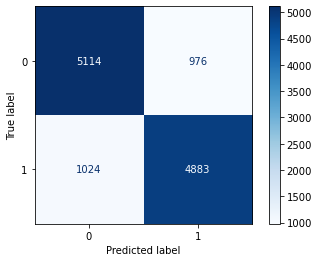

In [14]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.6967344242620778

Base Model Accuracy: 0.707

METRICS:
Accuracy score:
0.7071767941985496

Recall score:
0.7071767941985496

Precison score:
0.7074790560002674

F1-score:
0.7071048441615977

MCC score:
0.4146875143305593

Confusion matrix:
[[4325 1650]
 [1863 4159]]

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      5975
           1       0.72      0.69      0.70      6022

    accuracy                           0.71     11997
   macro avg       0.71      0.71      0.71     11997
weighted avg       0.71      0.71      0.71     11997




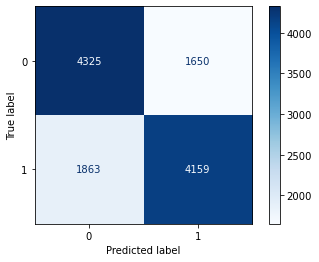

In [15]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors

Cross Validation accuracy score: 0.7936196882501029

Base Model Accuracy: 0.797

{'leaf_size': 30, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.815

Optimized model improved 2.164% over base model.

METRICS:
Accuracy score:
0.8145369675752271

Recall score:
0.8145369675752271

Precison score:
0.81501094796687

F1-score:
0.8144392063275383

MCC score:
0.6294922242154073

Confusion matrix:
[[5042  991]
 [1234 4730]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6033
           1       0.83      0.79      0.81      5964

    accuracy                           0.81     11997
   macro avg       0.82      0.81      0.81     11997
weighted avg       0.82      0.81      0.81     11997




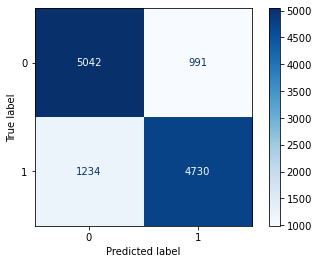

In [16]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.7674695201849511

Base Model Accuracy: 0.777

METRICS:
Accuracy score:
0.7770275902308911

Recall score:
0.7770275902308911

Precison score:
0.7781368131495846

F1-score:
0.7767959677161521

MCC score:
0.5551499090386763

Confusion matrix:
[[4857 1147]
 [1528 4465]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      6004
           1       0.80      0.75      0.77      5993

    accuracy                           0.78     11997
   macro avg       0.78      0.78      0.78     11997
weighted avg       0.78      0.78      0.78     11997




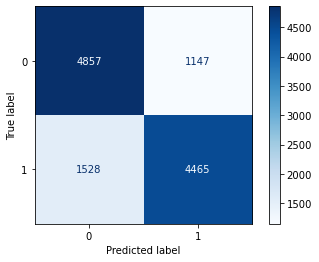

In [17]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network

Cross Validation accuracy score: 0.8001932412648841

Base Model Accuracy: 0.798

{'activation': 'tanh', 'learning_rate': 'invscaling'}

Optimized Model Accuracy: 0.801

Optimized model improved 0.345% over base model.

METRICS:
Accuracy score:
0.8011169459031424

Recall score:
0.8011169459031424

Precison score:
0.8011195746600436

F1-score:
0.8011168353572717

MCC score:
0.6022366725614786

Confusion matrix:
[[4803 1201]
 [1185 4808]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6004
           1       0.80      0.80      0.80      5993

    accuracy                           0.80     11997
   macro avg       0.80      0.80      0.80     11997
weighted avg       0.80      0.80      0.80     11997




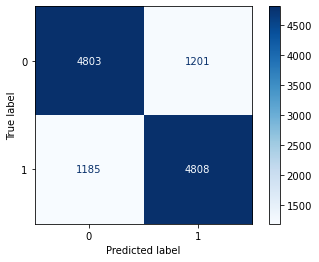

In [18]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Descriptors without feature selection

In [ ]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_binary.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_data_b = StandardScaler().fit_transform(descriptors_data_b)
descriptors_label_b = descriptors["activity"]

### Random Forest

In [ ]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

comparaçao

## Fingerprints

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_b, fingerprint_label_b, test_size=0.3)

### Random Forest

Cross Validation accuracy score: 0.8015575753874795

Base Model Accuracy: 0.816

{'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 210}

Optimized Model Accuracy: 0.820

Optimized model improved 0.562% over base model.

METRICS:
Accuracy score:
0.8203717596065683

Recall score:
0.8203717596065683

Precison score:
0.8205397270938765

F1-score:
0.8203324861962663

MCC score:
0.6408756689014522

Confusion matrix:
[[5028 1004]
 [1151 4814]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      6032
           1       0.83      0.81      0.82      5965

    accuracy                           0.82     11997
   macro avg       0.82      0.82      0.82     11997
weighted avg       0.82      0.82      0.82     11997




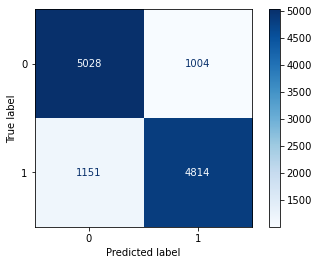

In [19]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.665309275038332

Base Model Accuracy: 0.658

METRICS:
Accuracy score:
0.6579144786196549

Recall score:
0.6579144786196549

Precison score:
0.6579471064272943

F1-score:
0.6579143360127254

MCC score:
0.31586186548716466

Confusion matrix:
[[3946 2082]
 [2022 3947]]

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      6028
           1       0.65      0.66      0.66      5969

    accuracy                           0.66     11997
   macro avg       0.66      0.66      0.66     11997
weighted avg       0.66      0.66      0.66     11997




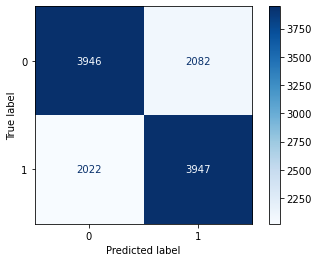

In [20]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors

Cross Validation accuracy score: 0.7755867189319074

Base Model Accuracy: 0.784

{'leaf_size': 20, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.804

Optimized model improved 2.595% over base model.

METRICS:
Accuracy score:
0.8041176960906894

Recall score:
0.8041176960906894

Precison score:
0.8080916250182635

F1-score:
0.8034134789190079

MCC score:
0.6120798437521021

Confusion matrix:
[[5197  830]
 [1520 4450]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82      6027
           1       0.84      0.75      0.79      5970

    accuracy                           0.80     11997
   macro avg       0.81      0.80      0.80     11997
weighted avg       0.81      0.80      0.80     11997




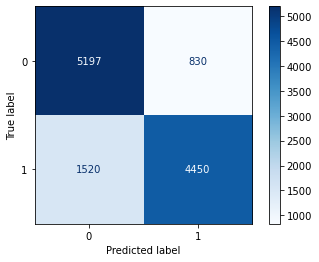

In [21]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.7471509515843339

Base Model Accuracy: 0.760

METRICS:
Accuracy score:
0.7596899224806202

Recall score:
0.7596899224806202

Precison score:
0.76041145989187

F1-score:
0.7595969494836776

MCC score:
0.5201663853394132

Confusion matrix:
[[4652 1295]
 [1588 4462]]

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5947
           1       0.78      0.74      0.76      6050

    accuracy                           0.76     11997
   macro avg       0.76      0.76      0.76     11997
weighted avg       0.76      0.76      0.76     11997




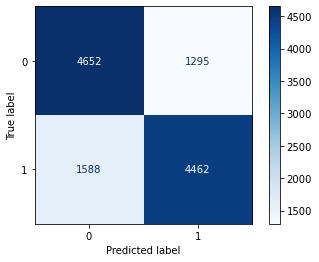

In [22]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network

Cross Validation accuracy score: 0.7750150351581819

Base Model Accuracy: 0.782

{'activation': 'relu', 'learning_rate': 'invscaling'}

Optimized Model Accuracy: 0.781

Optimized model improved -0.053% over base model.

METRICS:
Accuracy score:
0.781695423855964

Recall score:
0.781695423855964

Precison score:
0.7816934058802414

F1-score:
0.7816928451809112

MCC score:
0.5633636498870724

Confusion matrix:
[[4639 1318]
 [1301 4739]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5957
           1       0.78      0.78      0.78      6040

    accuracy                           0.78     11997
   macro avg       0.78      0.78      0.78     11997
weighted avg       0.78      0.78      0.78     11997




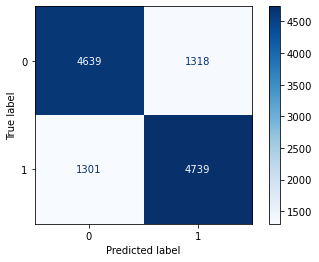

In [23]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Comparation

TABLE HERE

# Multiclass

### Load data

In [24]:
descriptors = pd.read_csv('../dataset/multiclass/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/multiclass/rdk_fs.csv', sep=',')

descriptors_data_m = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_m = descriptors["Activity at 46.23 uM"]
fingerprint_data_m = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_m = fingerprint["Activity at 46.23 uM"]

## Descriptors

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_m, descriptors_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation accuracy score: 0.563946638253488

Base Model Accuracy: 0.572

{'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 210}

Optimized Model Accuracy: 0.575

Optimized model improved 0.642% over base model.

METRICS:
Accuracy score:
0.575227140118363

Recall score:
0.575227140118363

Precison score:
0.5353013516612782

F1-score:
0.5168199335001102

MCC score:
0.3574525635356896

Confusion matrix:
[[ 143 1163  296    3]
 [ 149 3297  950   15]
 [  18  833 3368  161]
 [   3  177 1328   93]]

Classification report:
              precision    recall  f1-score   support

           0       0.46      0.09      0.15      1605
           1       0.60      0.75      0.67      4411
           2       0.57      0.77      0.65      4380
           3       0.34      0.06      0.10      1601

    accuracy                           0.58     11997
   macro avg       0.49      0.42      0.39     11997
weighted avg       0.54      0.58      0.52     11997




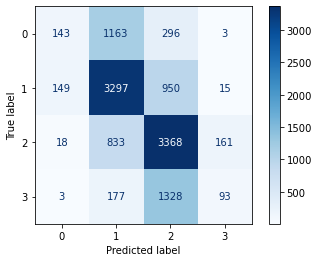

In [25]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.3935058198584816

Base Model Accuracy: 0.397

METRICS:
Accuracy score:
0.3973493373343336

Recall score:
0.3973493373343336

Precison score:
0.4058501290111436

F1-score:
0.388028234845088

MCC score:
0.16275122554902954

Confusion matrix:
[[ 242  865  294  231]
 [ 517 2563  889  448]
 [ 184 1214 1151 1760]
 [  56  336  436  811]]

Classification report:
              precision    recall  f1-score   support

           0       0.24      0.15      0.18      1632
           1       0.51      0.58      0.55      4417
           2       0.42      0.27      0.33      4309
           3       0.25      0.49      0.33      1639

    accuracy                           0.40     11997
   macro avg       0.36      0.37      0.35     11997
weighted avg       0.41      0.40      0.39     11997




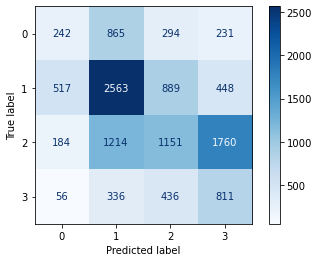

In [26]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Classifier

Cross Validation accuracy score: 0.5166477439031277

Base Model Accuracy: 0.523

{'leaf_size': 30, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.552

Optimized model improved 5.532% over base model.

METRICS:
Accuracy score:
0.551804617821122

Recall score:
0.551804617821122

Precison score:
0.5118843979935901

F1-score:
0.5165410851772404

MCC score:
0.32831677912751794

Confusion matrix:
[[ 207 1069  294   16]
 [ 350 3042  967   70]
 [  61  740 3154  397]
 [  11  172 1230  217]]

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.13      0.19      1586
           1       0.61      0.69      0.64      4429
           2       0.56      0.72      0.63      4352
           3       0.31      0.13      0.19      1630

    accuracy                           0.55     11997
   macro avg       0.45      0.42      0.41     11997
weighted avg       0.51      0.55      0.52     11997




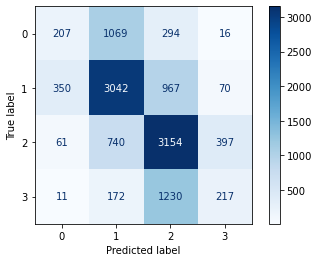

In [27]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.4961419002436318

Base Model Accuracy: 0.513

METRICS:
Accuracy score:
0.5130449278986413

Recall score:
0.5130449278986413

Precison score:
0.4924136605970901

F1-score:
0.49560174636436144

MCC score:
0.28157634782535407

Confusion matrix:
[[ 174  980  297   92]
 [ 299 2939  938  197]
 [  70  972 2547  872]
 [  29  219  877  495]]

Classification report:
              precision    recall  f1-score   support

           0       0.30      0.11      0.16      1543
           1       0.58      0.67      0.62      4373
           2       0.55      0.57      0.56      4461
           3       0.30      0.31      0.30      1620

    accuracy                           0.51     11997
   macro avg       0.43      0.42      0.41     11997
weighted avg       0.49      0.51      0.50     11997




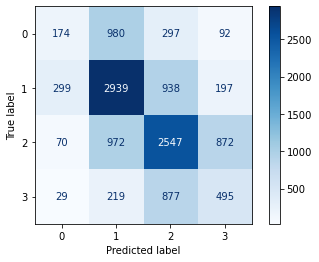

In [28]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Classifier

Cross Validation accuracy score: 0.555015495864143

Base Model Accuracy: 0.561

{'activation': 'tanh', 'learning_rate': 'adaptive'}

Optimized Model Accuracy: 0.556

Optimized model improved -0.832% over base model.

METRICS:
Accuracy score:
0.5608902225556389

Recall score:
0.5608902225556389

Precison score:
0.529934108289522

F1-score:
0.4819057720049258

MCC score:
0.331488424285268

Confusion matrix:
[[  48 1195  340    1]
 [  54 3379  978    0]
 [   9 1053 3293   10]
 [   0  256 1372    9]]

Classification report:
              precision    recall  f1-score   support

           0       0.43      0.03      0.06      1584
           1       0.57      0.77      0.66      4411
           2       0.55      0.75      0.64      4365
           3       0.45      0.01      0.01      1637

    accuracy                           0.56     11997
   macro avg       0.50      0.39      0.34     11997
weighted avg       0.53      0.56      0.48     11997




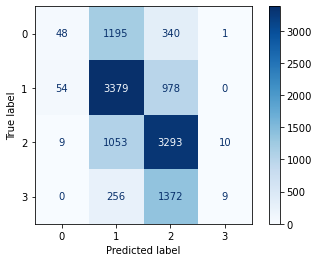

In [29]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

### Undersampling

In [ ]:
ml(rf, data_train, data_test, label_train, label_test, params_rf, sampling=True)

## Fingerprints

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_m, fingerprint_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation accuracy score: 0.5484230424192142

Base Model Accuracy: 0.546

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 210}

Optimized Model Accuracy: 0.548

Optimized model improved 0.458% over base model.

METRICS:
Accuracy score:
0.5483870967741935

Recall score:
0.5483870967741935

Precison score:
0.5094890839063946

F1-score:
0.5149232844489811

MCC score:
0.3214667763615083

Confusion matrix:
[[ 229 1018  292   12]
 [ 389 2981  944   57]
 [  46  823 3164  411]
 [  10  215 1201  205]]

Classification report:
              precision    recall  f1-score   support

           0       0.34      0.15      0.21      1551
           1       0.59      0.68      0.63      4371
           2       0.56      0.71      0.63      4444
           3       0.30      0.13      0.18      1631

    accuracy                           0.55     11997
   macro avg       0.45      0.42      0.41     11997
weighted avg       0.51      0.55      0.51     11997




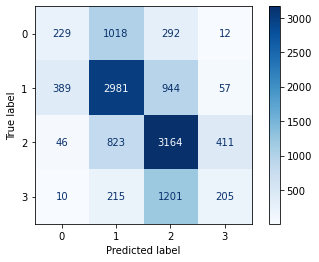

In [30]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.3443003813075639

Base Model Accuracy: 0.348

METRICS:
Accuracy score:
0.34817037592731515

Recall score:
0.34817037592731515

Precison score:
0.3911982434705235

F1-score:
0.3526614849137124

MCC score:
0.12771329098294856

Confusion matrix:
[[ 445  667  261  277]
 [1040 1906  783  681]
 [ 476  998 1030 1803]
 [ 149  327  358  796]]

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.27      0.24      1650
           1       0.49      0.43      0.46      4410
           2       0.42      0.24      0.31      4307
           3       0.22      0.49      0.31      1630

    accuracy                           0.35     11997
   macro avg       0.34      0.36      0.33     11997
weighted avg       0.39      0.35      0.35     11997




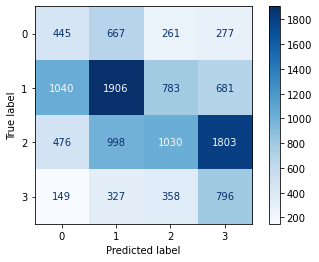

In [31]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Classifier

Cross Validation accuracy score: 0.5169862606890004

Base Model Accuracy: 0.519

{'leaf_size': 20, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.541

Optimized model improved 4.125% over base model.

METRICS:
Accuracy score:
0.54080186713345

Recall score:
0.54080186713345

Precison score:
0.5118754720682028

F1-score:
0.5143145470406674

MCC score:
0.3164430876903785

Confusion matrix:
[[ 293  954  353   37]
 [ 408 2710 1159   97]
 [  74  612 3248  481]
 [  21  139 1174  237]]

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.18      0.24      1637
           1       0.61      0.62      0.62      4374
           2       0.55      0.74      0.63      4415
           3       0.28      0.15      0.20      1571

    accuracy                           0.54     11997
   macro avg       0.45      0.42      0.42     11997
weighted avg       0.51      0.54      0.51     11997




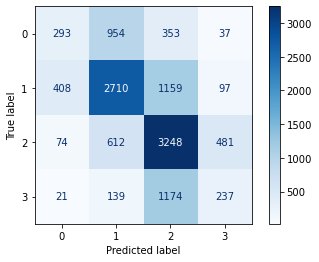

In [32]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.48176343948521916

Base Model Accuracy: 0.484

METRICS:
Accuracy score:
0.4837042593981829

Recall score:
0.4837042593981829

Precison score:
0.4777098481521277

F1-score:
0.47665120002509037

MCC score:
0.2524074739692947

Confusion matrix:
[[ 234  943  263  143]
 [ 382 2762  904  365]
 [ 141  861 2301 1071]
 [  45  222  854  506]]

Classification report:
              precision    recall  f1-score   support

           0       0.29      0.15      0.20      1583
           1       0.58      0.63      0.60      4413
           2       0.53      0.53      0.53      4374
           3       0.24      0.31      0.27      1627

    accuracy                           0.48     11997
   macro avg       0.41      0.40      0.40     11997
weighted avg       0.48      0.48      0.48     11997




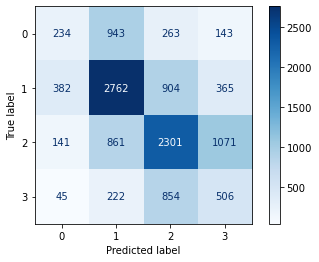

In [33]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Classifier

Cross Validation accuracy score: 0.5320620720244217

Base Model Accuracy: 0.550

{'activation': 'tanh', 'learning_rate': 'invscaling'}

Optimized Model Accuracy: 0.548

Optimized model improved -0.379% over base model.

METRICS:
Accuracy score:
0.5497207635242144

Recall score:
0.5497207635242144

Precison score:
0.49153190681590936

F1-score:
0.4821873995655315

MCC score:
0.31092571968534516

Confusion matrix:
[[  34 1204  374   15]
 [  55 3303 1073   40]
 [  13 1053 3189  114]
 [   3  231 1227   69]]

Classification report:
              precision    recall  f1-score   support

           0       0.32      0.02      0.04      1627
           1       0.57      0.74      0.64      4471
           2       0.54      0.73      0.62      4369
           3       0.29      0.05      0.08      1530

    accuracy                           0.55     11997
   macro avg       0.43      0.38      0.35     11997
weighted avg       0.49      0.55      0.48     11997




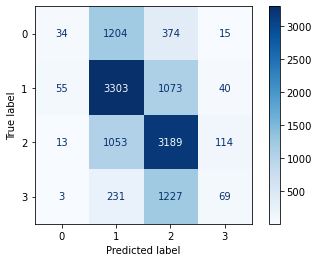

In [34]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Regression

### Load data

In [ ]:
descriptors = pd.read_csv('../dataset/regression/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/regression/rdk_fs.csv', sep=',')

descriptors_data_r = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_r = descriptors["Activity at 46.23 uM"]
fingerprint_data_r = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_r = fingerprint["Activity at 46.23 uM"]

### Models

In [ ]:
rf = RandomForestRegressor(n_jobs=4)
lr = LinearRegression()
knn = KNeighborsRegressor(n_jobs=4)
voting = VotingRegressor(estimators=[('Random Forest', rf), ('Linear Regression', lr), ('KNN', knn)], n_jobs=4)
nn = MLPRegressor(early_stopping=True)

## Descriptors

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_r, descriptors_label_r, test_size=0.3)

### Random Forest Regressor

In [ ]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Linear Regression

In [ ]:
ml(lr, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Regressor

In [ ]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Regressor

In [ ]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Regressor

In [ ]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Fingerprints

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_r, fingerprint_label_r, test_size=0.3)

### Random Forest Regressor

In [ ]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Linear Regression

In [ ]:
ml(lr, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Regressor

In [ ]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Regressor

In [ ]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Regressor

In [ ]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)